In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
sp = pd.read_csv('../data/sp1950.csv')
#sp['Date'] = pd.to_datetime(sp.Date)
sp = sp[['Date', 'Open', 'Close', 'Adj Close']]
sp = sp.rename(columns={'Adj Close': 'Value'})
sp.head()

,Date,Open,Close,Value
0,1/3/50,16.66,16.66,16.66
1,1/4/50,16.85,16.85,16.85
2,1/5/50,16.93,16.93,16.93
3,1/6/50,16.98,16.98,16.98
4,1/9/50,17.08,17.08,17.08


In [3]:
sp.tail()

,Date,Open,Close,Value
17383,2/4/19,2702.320068,2724.87,2724.87
17384,2/5/19,2702.320068,2737.70,2724.87
17385,2/6/19,2702.320068,2731.61,2731.61
17386,2/7/19,2702.320068,2706.05,2706.05
17387,2/8/19,2702.320068,2707.88,2707.88


In [4]:
def date2datetime(date):
    month, day, year = date.split('/')
    if int(year) > 20:
        year = int(year) + 1900
    else:
        year = int(year) + 2000
    try:
        return pd.to_datetime(f'{year}-{month}-{day}')
    except:
        print(date)

In [5]:
date2datetime('1/3/50')

Timestamp('1950-01-03 00:00:00')

In [6]:
sp.Date = sp.Date.apply(date2datetime)
sp.head()

,Date,Open,Close,Value
0,1950-01-03,16.66,16.66,16.66
1,1950-01-04,16.85,16.85,16.85
2,1950-01-05,16.93,16.93,16.93
3,1950-01-06,16.98,16.98,16.98
4,1950-01-09,17.08,17.08,17.08


In [7]:
sp['ChangeSinceOpen'] = sp['Close'] / sp['Open']
sp.tail()

,Date,Open,Close,Value,ChangeSinceOpen
17383,2019-02-04,2702.320068,2724.87,2724.87,1.008345
17384,2019-02-05,2702.320068,2737.70,2724.87,1.013092
17385,2019-02-06,2702.320068,2731.61,2731.61,1.010839
17386,2019-02-07,2702.320068,2706.05,2706.05,1.001380
17387,2019-02-08,2702.320068,2707.88,2707.88,1.002057


In [8]:
sp['DailyChange'] = np.nan
sp['OvernightChange'] = np.nan
for day in range(1, sp.shape[0]):
    sp.loc[day, 'DailyChange'] = (sp.loc[day, 'Value'] 
                                  / sp.loc[day - 1, 'Value'])
    sp.loc[day, 'OvernightChange'] = (sp.loc[day, 'Open'] 
                                      / sp.loc[day - 1, 'Close'])
    #if day < 3000 and sp.loc[day, 'ChangeSinceOpen'] == 1.:
    #    sp.loc[day, 'ChangeSinceOpen'] = sp.loc[day, 'DailyChange']
sp.tail()        

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange
17383,2019-02-04,2702.320068,2724.87,2724.87,1.008345,1.006776,0.998445
17384,2019-02-05,2702.320068,2737.70,2724.87,1.013092,1.000000,0.991724
17385,2019-02-06,2702.320068,2731.61,2731.61,1.010839,1.002474,0.987077
17386,2019-02-07,2702.320068,2706.05,2706.05,1.001380,0.990643,0.989277
17387,2019-02-08,2702.320068,2707.88,2707.88,1.002057,1.000676,0.998622


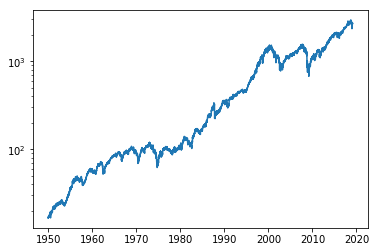

In [9]:
plt.plot(sp.Date, sp.Value);
plt.yscale('log');

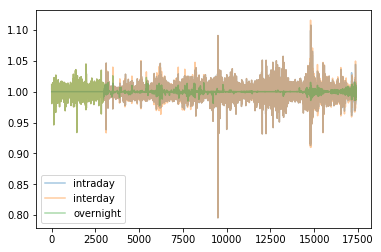

In [10]:
plt.plot(sp.ChangeSinceOpen, alpha=0.4, label='intraday')
plt.plot(sp.DailyChange, alpha=0.4, label='interday')
plt.plot(sp.OvernightChange, alpha=0.4, label='overnight')
plt.legend();

In [11]:
#list(sp['ChangeSinceOpen'] > 1.).index(True) # 3014
#(sp['ChangeSinceOpen'][:3013] == 1).all() # True
#(sp['ChangeSinceOpen'][:3014] == 1).all() # False
sp = sp.loc[3014:, :]
sp.index = range(sp.shape[0])

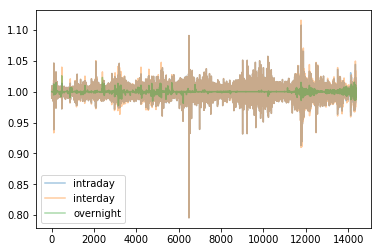

In [12]:
plt.plot(sp.ChangeSinceOpen, alpha=0.4, label='intraday')
plt.plot(sp.DailyChange, alpha=0.4, label='interday')
plt.plot(sp.OvernightChange, alpha=0.4, label='overnight')
plt.legend();

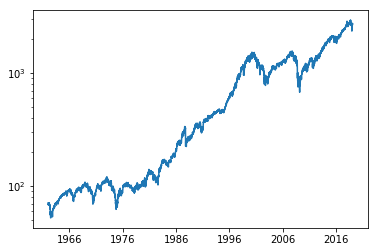

In [13]:
plt.plot(sp.Date, sp.Value);
plt.yscale('log');

In [14]:
def moving_dev_signals(x, params):
    '''
    @params
    x: list: time series of prices
    params: list: [up_qs, up_amounts, down_qs, down_amounts]
    up_qs, down_qs: lists: quantiles for which, moving upward/downward 
        across signals an action
    up_amounts, down_amounts: lists: amount to put in (+) or take out (-)
        associated with each up signal (qs)
    @return: array of signals (usually just one, but multiple events may
        occur on a single day)
    '''
    up_qs, up_amounts, down_qs, down_amounts = params
    x = x.tolist()
    n = len(x)
    up_qs = np.quantile(x, up_qs)
    down_qs = np.quantile(x, down_qs)
    signals = []
    for q, action in zip(up_qs, up_amounts):
        if x[n - 2] < q and x[n - 1] > q:
            signals.append(action)
    for q, action in zip(down_qs, down_amounts):
        if x[n - 2] > q and x[n - 1] < 1:
            signals.append(action)
    return signals if signals else [0]

In [15]:
def sliding_window(x, window, func, **kwargs):
    '''
    Apply the function func to each frame of a timeseries, x with a moving
    window, window
    
    @params
    x: list: the complete time series of prices
    window: int: the number of days to apply the function to
    func: function: a function that takes a time series as input and 
        returns a list of one or more signals each day, where a signal is
        the percentage of money to put in or take out
    **kwargs: additional arguments to pass to func
    @return: a list of lists, each list in the primary list is a list of 
        signals for each single day
    '''
    n = len(x)
    all_signals = [[0] for _ in range(window)]
    for w in range(window, n):
        signals = func(x[(w - window):w], **kwargs)
        all_signals.append(signals)
    return all_signals

In [16]:
# Test 
x = sp.Value
up_qs = [0.05, 0.45]
up_amounts = [0.9, 0.3]
down_qs = [0.95, 0.55]
down_amounts = [-0.7, -0.9]
params = [up_qs, up_amounts, down_qs, down_amounts]
window = 30

#actions = sliding_window(x, 
#                         window, 
#                         moving_dev_signals,
#                         up_qs=up_qs, 
#                         up_amounts=up_amounts, 
#                         down_qs=down_qs,
#                         down_amounts=down_amounts)
# The action based on today gets applied tomorrow
#actions = [0] + actions[:-1] 

In [17]:
def generate_actions(sp, window, func, params):
    x = sp.Value
    actions = sliding_window(x, window, func, params=params)
    actions = [0] + actions[:-1]
    sp['Actions'] = actions
    return sp

In [18]:
sp = generate_actions(sp, 30, moving_dev_signals, params=params)
sp.tail()

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange,Actions
14369,2019-02-04,2702.320068,2724.87,2724.87,1.008345,1.006776,0.998445,[0]
14370,2019-02-05,2702.320068,2737.70,2724.87,1.013092,1.000000,0.991724,[0]
14371,2019-02-06,2702.320068,2731.61,2731.61,1.010839,1.002474,0.987077,[0]
14372,2019-02-07,2702.320068,2706.05,2706.05,1.001380,0.990643,0.989277,[0]
14373,2019-02-08,2702.320068,2707.88,2707.88,1.002057,1.000676,0.998622,[0]


In [19]:
init_amount = sp.Value[0]
init_amount

71.129997

In [20]:
sp['Reserve'] = np.nan
sp['Invested'] = np.nan
sp.loc[0, 'Reserve'] = init_amount
sp.loc[0, 'Invested'] = 0.
sp.head()

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange,Actions,Reserve,Invested
0,1962-01-03,70.959999,71.129997,71.129997,1.002396,1.002396,1.0,0,71.129997,0.0
1,1962-01-04,71.129997,70.639999,70.639999,0.993111,0.993111,1.0,[0],NaN,NaN
2,1962-01-05,70.639999,69.660004,69.660004,0.986127,0.986127,1.0,[0],NaN,NaN
3,1962-01-08,69.660004,69.120003,69.120003,0.992248,0.992248,1.0,[0],NaN,NaN
4,1962-01-09,69.120003,69.150002,69.150002,1.000434,1.000434,1.0,[0],NaN,NaN


In [21]:
def update_values(row):
    reserve = row['Reserve']
    invested = row['Invested']
    change_since_open = row['ChangeSinceOpen']
    overnight_change = row['OvernightChange']
    invested *= overnight_change
    money_per_action = 0
    for action in row['Actions']:
        if action > 0: # Buy
            money_per_action = reserve * action
        if action < 0: # Sell
            money_per_action = invested * action    
        reserve -= money_per_action
        invested += money_per_action
    invested *= change_since_open
    return reserve, invested

In [22]:
def predict_performance(sp):
    for day in range(1, sp.shape[0]):
        sp.loc[day, ['Reserve', 'Invested']] = sp.loc[
            day - 1, ['Reserve', 'Invested']]
        sp.loc[day, ['Reserve', 'Invested']] = update_values(
            sp.loc[day, :])
        sp['Total'] = sp['Reserve'] + sp['Invested']
    return sp

In [23]:
sp = predict_performance(sp)
sp.tail()

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange,Actions,Reserve,Invested,Total
14369,2019-02-04,2702.320068,2724.87,2724.87,1.008345,1.006776,0.998445,[0],0.0,2768.075524,2768.075524
14370,2019-02-05,2702.320068,2737.70,2724.87,1.013092,1.000000,0.991724,[0],0.0,2781.108956,2781.108956
14371,2019-02-06,2702.320068,2731.61,2731.61,1.010839,1.002474,0.987077,[0],0.0,2774.922393,2774.922393
14372,2019-02-07,2702.320068,2706.05,2706.05,1.001380,0.990643,0.989277,[0],0.0,2748.957114,2748.957114
14373,2019-02-08,2702.320068,2707.88,2707.88,1.002057,1.000676,0.998622,[0],0.0,2750.816131,2750.816131


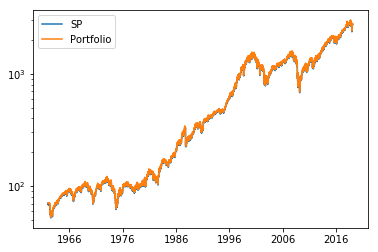

In [24]:
plt.plot(sp.Date, sp.Value, label='SP')
plt.plot(sp.Date, sp.Total, label='Portfolio');
plt.yscale('log');
plt.legend();

In [25]:
sp.Total.tolist()[-1]

2750.816130513769

# Repeat Search from Here

### 3-Deviations per direction (private portfolio)

In [38]:
ITERS = 100
best_yet = 6401.08
best_params = [
    [0.7444853760798101, 0.7268519565262801, 0.11631352067299794], 
    [0.5736752417317599, 0.9718231803601413, -0.21136722814495337], 
    [0.7327549938313901, 0.2953861402342123, 0.3138140846109865], 
    [0.9364925145562178, 0.3941335437002613, -0.7709318082357525]]
best_window = 204
print(f'best yet: {best_yet}\nbest params:\n{best_params}\n'
      f'best window:{best_window}')
sd = 0.004

best yet: 6401.08
best params:
[[0.7444853760798101, 0.7268519565262801, 0.11631352067299794], [0.5736752417317599, 0.9718231803601413, -0.21136722814495337], [0.7327549938313901, 0.2953861402342123, 0.3138140846109865], [0.9364925145562178, 0.3941335437002613, -0.7709318082357525]]
best window:204


In [39]:
def init_values(sd, init_window, init_params, min_window=10):
    up_qs, up_amts, down_qs, down_amts = init_params
    def trunc_normal(mean, sd, minval, maxval):
        val = np.random.normal(mean, scale=sd)
        val = max(min(val, maxval), minval)
        return val
    
    window = int(round(trunc_normal(init_window, 400*sd, min_window, 500)))
    up_q1   = trunc_normal(up_qs[0], sd, 0.05, 0.95)
    up_q2   = trunc_normal(up_qs[1], sd, 0.05, 0.95)
    up_q3   = trunc_normal(up_qs[2], sd, 0.05, 0.95)
    down_q1 = trunc_normal(down_qs[0], sd, 0.05, 0.95)
    down_q2 = trunc_normal(down_qs[1], sd, 0.05, 0.95)
    down_q3 = trunc_normal(down_qs[2], sd, 0.05, 0.95)
    up_amount1   = trunc_normal(up_amts[0], 2*sd, -1, 1)
    up_amount2   = trunc_normal(up_amts[1], 2*sd, -1, 1)
    up_amount3   = trunc_normal(up_amts[2], 2*sd, -1, 1)
    down_amount1 = trunc_normal(down_amts[0], 2*sd, -1, 1)
    down_amount2 = trunc_normal(down_amts[1], 2*sd, -1, 1)
    down_amount3 = trunc_normal(down_amts[2], 2*sd, -1, 1)
    up_qs = [up_q1, up_q2, up_q3]
    down_qs = [down_q1, down_q2, down_q3]
    up_amounts = [up_amount1, up_amount2, up_amount3]
    down_amounts = [down_amount1, down_amount2, down_amount3]
    params = [up_qs, up_amounts, down_qs, down_amounts]
    return window, params

#init_values(sd, best_window, best_params)

 1: Final value: $ 6232.31 (window = 206)
 2: Final value: $ 6171.37 (window = 203)
 3: Final value: $ 6002.86 (window = 206)
 4: Final value: $ 6369.55 (window = 204)
 5: Final value: $ 6392.07 (window = 204)
 6: Final value: $ 6025.59 (window = 205)
 7: Final value: $ 5988.14 (window = 206)
 8: Final value: $ 6070.69 (window = 206)
 9: Final value: $ 6317.27 (window = 202)
10: Final value: $ 6119.07 (window = 207)
11: Final value: $ 6095.44 (window = 204)
12: Final value: $ 6291.41 (window = 204)
13: Final value: $ 6114.29 (window = 202)
14: Final value: $ 6240.96 (window = 203)
15: Final value: $ 6263.56 (window = 201)
16: Final value: $ 6318.51 (window = 202)
17: Final value: $ 6227.64 (window = 203)
18: Final value: $ 6124.42 (window = 207)
19: Final value: $ 6072.06 (window = 206)
20: Final value: $ 6121.21 (window = 205)
21: Final value: $ 6099.73 (window = 207)
22: Final value: $ 6231.48 (window = 203)
23: Final value: $ 6379.75 (window = 204)
24: Final value: $ 6038.19 (window

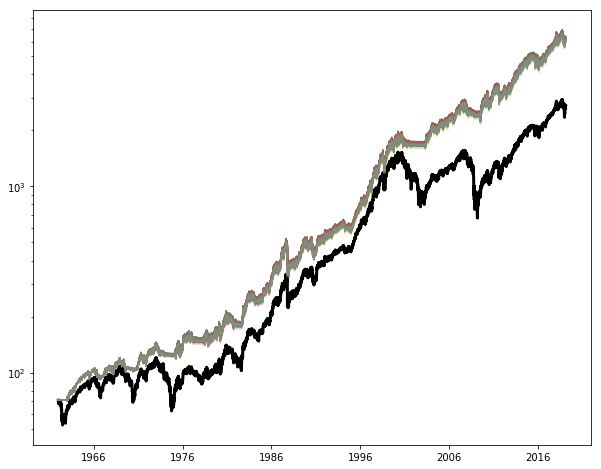

In [40]:
plt.figure(figsize=[10, 8])
plt.plot(sp.Date, sp.Value, 'k-', linewidth=3)
for i in range(ITERS):
    window, params = init_values(sd, best_window, best_params)
    sp = generate_actions(
        sp, window, func=moving_dev_signals, params=params)
    sp = predict_performance(sp)
    plt.plot(sp.Date, sp.Total, alpha=0.2);
    final_value = sp.Total.tolist()[-1]
    print(f'{i + 1:2d}: Final value: ${final_value:8.2f} '
          f'(window = {window})')
    if final_value > best_yet:
        print(f'New best model!\n{params}\nwindow: {window}')
        best_yet = final_value
        best_params = params
plt.yscale('log');    

### 2-Deviations per direction (401(k))

In [47]:
ITERS = 30
best_yet_401k = 5903.07 
best_params_401k = [
    [0.08298781850301395, 0.6319206753329255], 
    [-0.336705666692921, 0.9957561888736707], 
    [0.8076178202934372, 0.1948155305099095], 
    [0.4837710505551213, 1]]
best_window_401k = 283
print(f'best yet: {best_yet_401k}\nbest params:\n{best_params_401k}\n'
      f'best window:{best_window_401k}')
sd = 0.004

best yet: 5903.07
best params:
[[0.08298781850301395, 0.6319206753329255], [-0.336705666692921, 0.9957561888736707], [0.8076178202934372, 0.1948155305099095], [0.4837710505551213, 1]]
best window:283


In [48]:
def init_values(sd, init_window, init_params, min_window=60):
    up_qs, up_amts, down_qs, down_amts = init_params
    def trunc_normal(mean, sd, minval, maxval):
        val = np.random.normal(mean, scale=sd)
        val = max(min(val, maxval), minval)
        return val
    
    window = int(round(trunc_normal(init_window, 400*sd, min_window, 500)))
    up_q1   = trunc_normal(up_qs[0], sd, 0.05, 0.95)
    up_q2   = trunc_normal(up_qs[1], sd, 0.05, 0.95)
    down_q1 = trunc_normal(down_qs[0], sd, 0.05, 0.95)
    down_q2 = trunc_normal(down_qs[1], sd, 0.05, 0.95)
    up_amount1   = trunc_normal(up_amts[0], 2*sd, -1, 1)
    up_amount2   = trunc_normal(up_amts[1], 2*sd, -1, 1)
    down_amount1 = trunc_normal(down_amts[0], 2*sd, -1, 1)
    down_amount2 = trunc_normal(down_amts[1], 2*sd, -1, 1)
    up_qs = [up_q1, up_q2]
    down_qs = [down_q1, down_q2]
    up_amounts = [up_amount1, up_amount2]
    down_amounts = [down_amount1, down_amount2]
    params = [up_qs, up_amounts, down_qs, down_amounts]
    return window, params

#init_values(sd, best_window, best_params)

 1: Final value: $ 5663.40 (window = 283)
 2: Final value: $ 5756.16 (window = 282)
 3: Final value: $ 5746.44 (window = 282)
 4: Final value: $ 5594.36 (window = 281)
 5: Final value: $ 5597.50 (window = 284)
 6: Final value: $ 5064.12 (window = 287)
 7: Final value: $ 5694.91 (window = 284)
 8: Final value: $ 5695.32 (window = 283)
 9: Final value: $ 4689.41 (window = 282)
10: Final value: $ 5115.51 (window = 281)
11: Final value: $ 5244.70 (window = 283)
12: Final value: $ 5170.06 (window = 284)
13: Final value: $ 5752.62 (window = 281)
14: Final value: $ 5764.00 (window = 283)
15: Final value: $ 5807.45 (window = 284)
16: Final value: $ 5875.51 (window = 284)
17: Final value: $ 5222.88 (window = 279)
18: Final value: $ 5840.92 (window = 284)
19: Final value: $ 5707.38 (window = 283)
20: Final value: $ 5834.90 (window = 284)
21: Final value: $ 5813.87 (window = 282)
22: Final value: $ 5705.70 (window = 284)
23: Final value: $ 5714.90 (window = 286)
24: Final value: $ 5619.04 (window

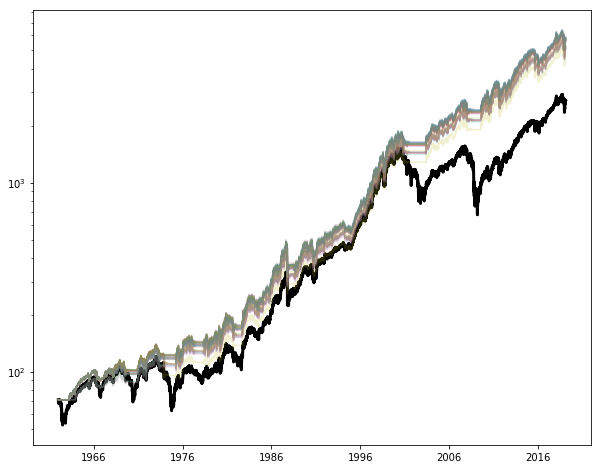

In [49]:
plt.figure(figsize=[10, 8])
plt.plot(sp.Date, sp.Value, 'k-', linewidth=3)
for i in range(ITERS):
    window_401k, params_401k = init_values(
        sd, best_window_401k, best_params_401k, min_window=60)
    sp = generate_actions(
        sp, window_401k, func=moving_dev_signals, params=params_401k)
    sp = predict_performance(sp)
    plt.plot(sp.Date, sp.Total, alpha=0.2);
    final_value_401k = sp.Total.tolist()[-1]
    print(f'{i + 1:2d}: Final value: ${final_value_401k:8.2f} '
          f'(window = {window_401k})')
    if final_value_401k > best_yet_401k:
        print(f'New best model!\n{params_401k}\nwindow: {window_401k}')
        best_yet_401k = final_value_401k
        best_params_401k = params_401k
plt.yscale('log');    